In [39]:
import cv2
import gval
import xarray as xr
import numpy as np
import rioxarray as rxr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.feature import corner_harris, corner_peaks
from scipy.spatial import distance

**Load candidate and benchmark maps**: Just a sample picked from GVAL repo

In [40]:


candidate = rxr.open_rasterio('./candidate_map_multi_categorical.tif', mask_and_scale=True)
benchmark = rxr.open_rasterio('./benchmark_map_multi_categorical.tif', mask_and_scale=True)

**Visualizing candidate and benchmark**

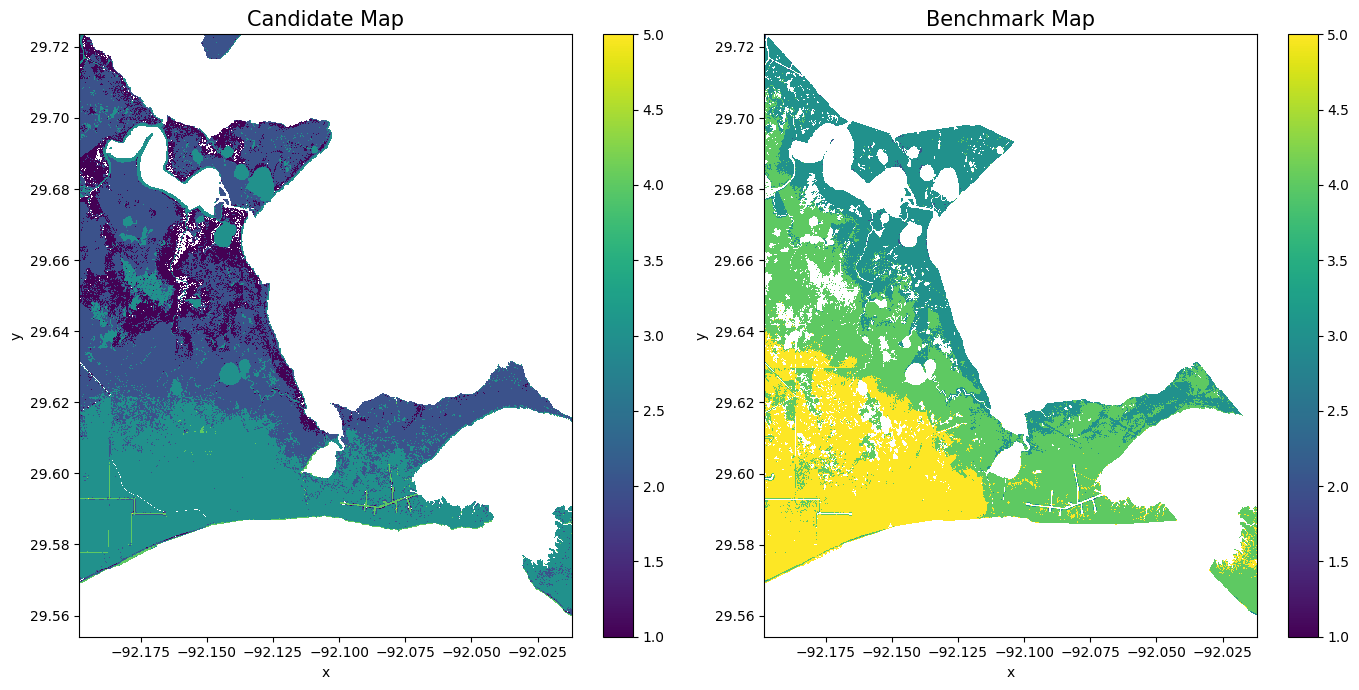

In [41]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

candidate.plot(ax=ax1, cmap='viridis')
ax1.set_title('Candidate Map', fontsize=15)

benchmark.plot(ax=ax2, cmap='viridis')
ax2.set_title('Benchmark Map', fontsize=15)

plt.tight_layout()
plt.show()

**Computing SSIM**

In [42]:

candidate, benchmark = candidate.gval.homogenize(benchmark)

candidate_data = candidate[0].data
benchmark_data = benchmark[0].data

# Replace NaN values with a 0
candidate_data = np.nan_to_num(candidate_data, nan=0)
benchmark_data = np.nan_to_num(benchmark_data, nan=0)

data_range = np.max([candidate_data.max(), benchmark_data.max()]) - np.min([candidate_data.min(), benchmark_data.min()])

if data_range == 0:
    data_range = 1

ssim_value, ssim_map = ssim(candidate_data, benchmark_data, data_range=data_range, full=True)

print(f"SSIM: {ssim_value}")

SSIM: 0.7333291097848849


**Visualizing the SSIM**

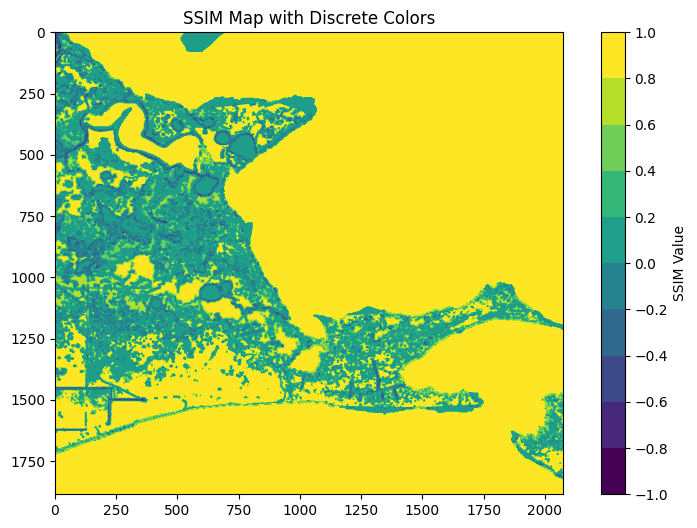

In [43]:
# Create a discrete colormap with 10 colors
n_colors = 10
cmap = plt.get_cmap('viridis', n_colors)  


bounds = np.linspace(-1, 1, n_colors + 1)  
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(10, 6))
img = plt.imshow(ssim_map, cmap=cmap, norm=norm)

plt.colorbar(img, ticks=bounds, label='SSIM Value')

plt.title('SSIM Map with Discrete Colors')

plt.show()

**Positive values between 0 and 1:** Indicate varying degrees of similarity. Closer to 1 means more similar; closer to 0 means less similar  
**Negative values (e.g., -1):** suggests strong structural dissimilarity, due to inversion or extreme differences

Below shows the SSIM on the map, we can also make it interactive

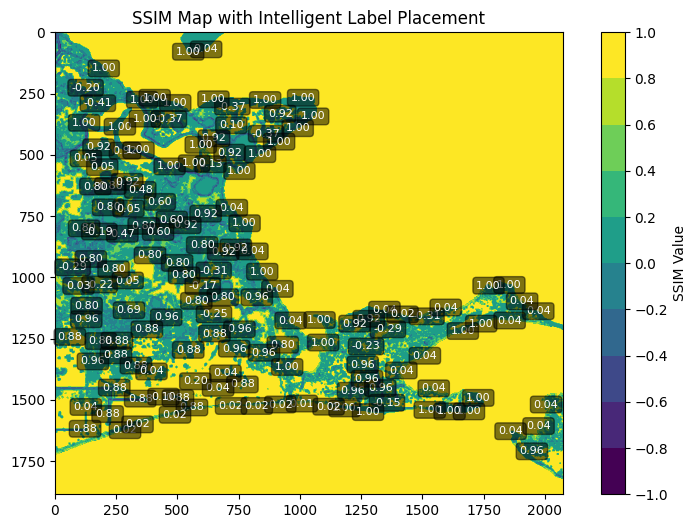

In [44]:


plt.figure(figsize=(10, 6))
img = plt.imshow(ssim_map, cmap=cmap, norm=norm)

plt.colorbar(img, ticks=bounds, label='SSIM Value')

corners = corner_peaks(corner_harris(ssim_map), min_distance=50, threshold_rel=0.01)

for corner in corners:
    i, j = corner
    value = ssim_map[i, j]
    plt.text(j, i, f'{value:.2f}', color='white', fontsize=8, ha='center', va='center',
             bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

plt.title('SSIM Map with Intelligent Label Placement')

plt.show()


**Calculating Mean Distance Error and Uncertainty**

In [45]:

candidate_flat = candidate_data.flatten()
benchmark_flat = benchmark_data.flatten()

# Calculate Mean Distance Error (MDE)
mde_value = np.mean(distance.cdist([candidate_flat], [benchmark_flat], metric='euclidean'))
print(f"Mean Distance Error (MDE): {mde_value}")

n_simulations = 100  
ssim_values = []
mde_values = []

for _ in range(n_simulations):
    # Add random Gaussian noise to both candidate and benchmark
    noise_candidate = candidate_data + np.random.normal(0, 0.01, candidate_data.shape)
    noise_benchmark = benchmark_data + np.random.normal(0, 0.01, benchmark_data.shape)
    
    noise_candidate_flat = noise_candidate.flatten()
    noise_benchmark_flat = noise_benchmark.flatten()
    
    # Calculate MDE for noisy data
    mde_sim = np.mean(distance.cdist([noise_candidate_flat], [noise_benchmark_flat], metric='euclidean'))
    mde_values.append(mde_sim)

    # Calculate SSIM for noisy data (optional)
    ssim_value, _ = ssim(noise_candidate, noise_benchmark, full=True, data_range=data_range)
    ssim_values.append(ssim_value)

mde_uncertainty = np.std(mde_values)
print(f"Uncertainty in MDE (Standard Deviation): {mde_uncertainty}")


Mean Distance Error (MDE): 2441.5765398610793
Uncertainty in MDE (Standard Deviation): 0.012987726720762914


Mean Distance Error (MDE) here measures the absolute numerical difference between corresponding points (pixels) in the candidate and benchmark maps.
In this case, the MDE of 2441.58 indicates that on average, there is a 2442 pixel difference between the two maps. refer to differences in water depth 
at each pixel or elevation differences between the flooded areas.

The Uncertainty in MDE (Standard Deviation of MDE) is 0.0138, which shows the stability of the MDE metric. I added small random noise to both maps. A small standard deviation 
like this indicates a robust comparison between the maps. In this case, the small uncertainty implies that the maps' differences are reliably captured by the MDE value.

**A high MDE, like 2441.57, indicates that while the general flooded areas may be similar (as indicated by SSIM), the magnitude of differences at each point is quite large.**